In [9]:
# Install all necessary libraries 
!pip install pandas
!pip install numpy
!pip install transformers torch scikit-learn
!pip install nltk
!pip install --upgrade nltk

# Clone the repository
!git clone https://github.com/dregmi08/Milestone-2-Data-Exploration-Initial-Preprocessing.git

# Import all necessary tools
import pandas as pd
import numpy as np

# Hugging Face libraries
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from transformers import pipeline
# PyTorch for model loading and inference
import torch

# For general text preprocessing (if needed before tokenization)
import re
import string

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


fatal: destination path 'Milestone-2-Data-Exploration-Initial-Preprocessing' already exists and is not an empty directory.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Model 1: Sentiment Classification
We are going to finetune our sentiment classification model using different preprocessing methods 

In [10]:
# Step 1: Dropping Columns

# Grab the csv file and convert to pandas dataframe
spotify_df = pd.read_csv('Milestone-2-Data-Exploration-Initial-Preprocessing/reviews.csv')

# New preprocessing decision: we are not going to make use of the Total_thumbs up column, the ranking in part 2 will
# be decided from the frequency of how often issues are complained about within reviews, and majority of the values in this column (over 60%)
# are 0. Since this doesn't have much relevance in how we decide rankings, we are going to drop this feature
spotify_df = spotify_df.drop(columns="Total_thumbsup")

# Drop the Time_submitted, the time a review submitted is completely irrelevant for ranking features and sentiment classification
spotify_df = spotify_df.drop(columns = ['Time_submitted'])

# Drop the Reply column, it doesn't affect the classification of the sentiment of the review nor would it help in ranking features
# in reviews
spotify_df = spotify_df.drop(columns = ['Reply'])

In [11]:
# Step 2: Preprocessing the text reviews
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")  # Make sure this is done before using the tokenizer

# Function to preprocess the review text
def preprocess_text(text):
    text = text.lower()  # Convert text to lowercase
    text = re.sub(f"[{string.punctuation}]", "", text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    return text

# Apply preprocessing to all reviews in the 'Review' column
spotify_df['Cleaned_Review'] = spotify_df['Review'].apply(preprocess_text)

# Tokenize the cleaned reviews
# Tokenize all reviews in the 'Cleaned_Review' column
tokenized_reviews = tokenizer(spotify_df['Cleaned_Review'].tolist(), padding=True, truncation=True, return_tensors="pt")


## Model 2: Ranking Features Algorithm Overview

### Last Model (Milestone 3 approach)
Last Model: For our ranking features, last time (Milestone 3) we used topic modeling to extract the most frequent topics/issues that came up amongst all of the reviews. With each topic, we used our model to come up with a corresponding sentiment score. We then took all of the negative topics, assigned a label to each topic, and then used a tool from hugging face to label the negative reviews using our labels to get a "ground truth". We then counted the frequency of labels after using the hugging face tool and then ranked the topics by frequency, and we used Kendall's Tau (a metric that compares rankings) to compare this ground truth ranking (the one produced by using the hugging face tool) to the one we got when using Latent Dirichlet Allocation (the topic modeling tool).

### Current Model (Milestone 4)
This time, our approach is going to be different. Instead of using topic modeling, and using another tool to label reviews for us in order to get a ground truth, we decided to label a randomly sampled small subset of the negative reviews with our own labels, and rank these labels/issues in terms of frequency to establish a ground truth. Instead of topic modeling, we decided to use Fuzzy clustering to group reviews together based on how similar they are. Since reviews can complain about a multitude of topics, we decided to go with fuzzy clustering since this would allow for a review to belong/be withing multiple clusters. We then counted the number of reviews within each cluster, and ranked this in terms of frequency. We the compared this ranking to the ranking we got from our manually labeled data with Kendall's Tau.

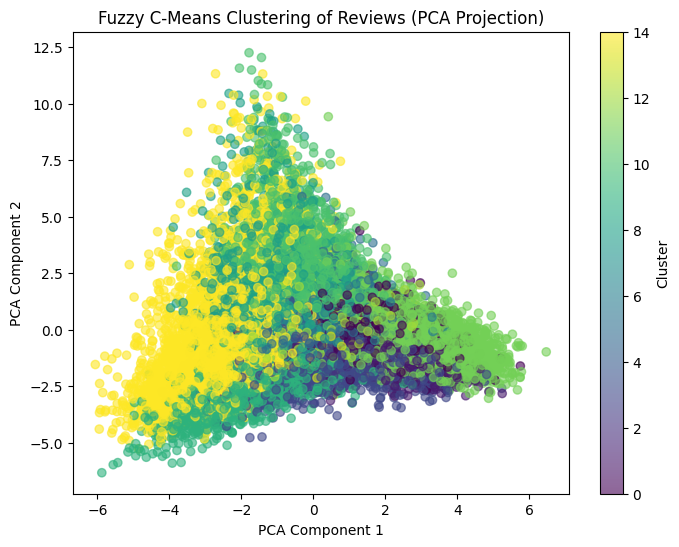

Cluster 0:
ads, song, songs, worst, playlist, ad, want, plays, listen, hour, hate, random, skips, premium, click, free, search, different, experience, internet, single, youtube, buy, connection, liked, play, bad, adding, favorite, instead

Cluster 1:
ads, song, play, playlist, plays, songs, shuffle, want, random, add, hate, list, like, press, choose, bad, hear, different, update, better, album, sucks, latest, click, pls, version, button, pick, added, feature

Cluster 2:
ads, song, listen, want, let, 30, ad, won, hate, uninterrupted, turn, mode, good, really, wanted, mins, annoying, minutes, didn, work, different, properly, choose, make, doesn, hear, comes, adds, star, min

Cluster 3:
play, song, playing, update, want, random, stop, bar, pause, plays, fix, shuffle, playlist, recent, close, dont, app, randomly, disappears, click, listen, notification, songs, controls, music, crashes, completely, broken, stops, pausing

Cluster 4:
crashing, fixed, problem, know, having, using, issue, time

In [41]:
import numpy as np
import pandas as pd
import skfuzzy as fuzz
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

np.random.seed(20)

# Step 1: Filter the negative reviews (Rating = 1 or 2)
filtered_negative_reviews = spotify_df[spotify_df['Rating'].isin([1, 2])].copy()

# Step 2: Convert text reviews into TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
reviews = filtered_negative_reviews['Review'].values
X = vectorizer.fit_transform(reviews).toarray()

# Step 3: Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Perform fuzzy c-means clustering (with 15 clusters)
c = 15  # Number of clusters
m = 2  # Fuzziness factor
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    X_scaled.T, c, m, error=0.005, maxiter=1000, init=None
)

# Step 5: Get cluster assignments
cluster_assignments = np.argmax(u, axis=0)

# Step 6: Directly assign the clusters to the original DataFrame
# Make sure to do this assignment using `.loc` to avoid SettingWithCopyWarning
spotify_df.loc[filtered_negative_reviews.index, 'Negative_Review_Cluster'] = cluster_assignments

# Step 7: Optionally visualize the clusters using PCA
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_assignments, cmap='viridis', alpha=0.6)
plt.title('Fuzzy C-Means Clustering of Reviews (PCA Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Step 8: Print the top terms for each cluster
terms = vectorizer.get_feature_names_out()
for i, center in enumerate(cntr):
    print(f"Cluster {i}:")
    sorted_idx = center.argsort()[-30:][::-1]  # Get top 30 terms
    top_terms = [terms[idx] for idx in sorted_idx]
    print(", ".join(top_terms))
    print()

# Step 9: Count the number of members in each cluster
cluster_counts = spotify_df['Negative_Review_Cluster'].value_counts()

# Sort clusters by size (descending order by default)
ranked_clusters = cluster_counts.sort_values(ascending=False)

# Display the rankings
print("Cluster rankings by size:")
print(ranked_clusters)


## Comparing to the ground truth
We decided to take 600 randomly sampled negative reviews, and we decided to label about 100/person. We then took the labels that everyone came up with, grouped them based on label similarity (if one person labeled a review "bad ui" and another person labeled a similar review "ui complaints" then we put these in the same group), and ranked based on the frequency of label groups.

In [ ]:
## Our ground truth ranking is as follows:
